In [1]:
# Look for *.tif files in all subfolders.
from os import walk
from os.path import join
import fnmatch
folderName = '/home/jiongyi/Documents/dna_damage/immunofluorescence/2018_12_28/u2os_wt_60_m_post_0gr_pH2AX_53pb1_dapi_a'
tifFilePaths = []
searchString = '*22_MMStack_Pos0.ome.tif'
for (dirPath, dirNames, fileNames) in walk(folderName):
    for fileName in fileNames:
        if fnmatch.fnmatch(fileName, searchString):
            tifFilePaths.append(join(dirPath, fileName))

In [2]:
from skimage.io import imread
from skimage import img_as_float
# Load stack.
currentFilePath = tifFilePaths[0]
currentStack = img_as_float(imread(currentFilePath))
# Restack.
noChannels, noSlices, noRows, noColumns = currentStack.shape
zLambda1Stack= currentStack[1, :, :, :]
zLambda2Stack = currentStack[2, :, :, :]
zLambda3Stack = currentStack[0, :, :, :]

In [3]:
from numpy import zeros, argmax, arange
from skimage.filters import sobel, gaussian
def extended_depth_field(stack):
    noStacks, noRows, noCols = stack.shape
    gaussStack = zeros((noStacks, noRows, noCols))
    sobelStack = zeros((noStacks, noRows, noCols))
    for i in range(noStacks):
        sobelStack[i, :, :] = sobel(stack[i, :, :])
    idxMaxEdgeImg = argmax(sobelStack, axis = 0)
    stack = stack.reshape((noStacks, -1))
    stack = stack.transpose()
    extDepthImg = stack[arange(len(stack)), idxMaxEdgeImg.ravel()]
    extDepthImg = extDepthImg.reshape((noRows, noCols))
    return gaussian(extDepthImg)

In [4]:
# Extended depth of field.
lambda1Arr = extended_depth_field(zLambda1Stack)
lambda2Arr = extended_depth_field(zLambda2Stack)
lambda3Arr = extended_depth_field(zLambda3Stack)

In [5]:
from skimage.morphology import erosion, reconstruction, disk, remove_small_objects
def tophat_reconstruction(rawArr, struct_elem):
    erodedArr = erosion(rawArr, struct_elem)
    openedArr = reconstruction(erodedArr, rawArr)
    return rawArr - openedArr

In [100]:
tophatLambda1Arr = tophat_reconstruction(lambda1Arr, disk(3))
tophatLambda2Arr = tophat_reconstruction(lambda2Arr, disk(3))

In [101]:
from skimage.filters import gaussian, threshold_otsu
gaussLambda3Arr = gaussian(lambda3Arr, sigma = 5)
bwLambda3Arr = gaussLambda3Arr > threshold_otsu(gaussLambda3Arr)

In [106]:
from skimage.segmentation import morphological_chan_vese

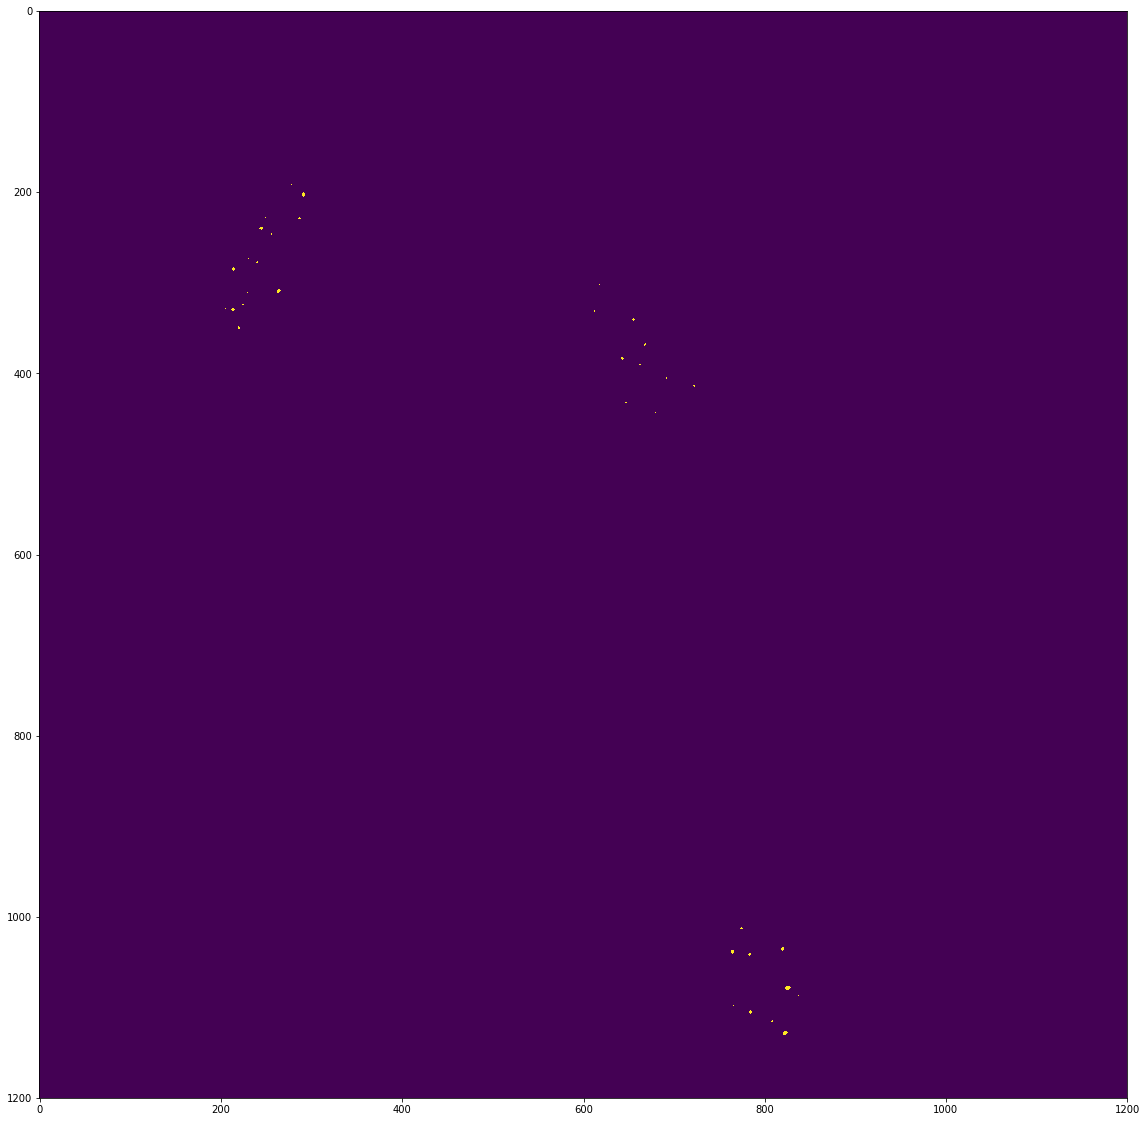

In [115]:
%matplotlib inline
from matplotlib.pyplot import subplots, hist, cm
from skimage.io import imshow
from skimage.segmentation import find_boundaries
from numpy import max, median
figObj, axesObj = subplots()
figObj.set_figheight(20)
figObj.set_figwidth(20)
axesObj.imshow(morphological_chan_vese(tophatLambda1Arr, 100, init_level_set = bwLambda3Arr))